## 1. Data Pre-processing

### 1.1 Load Data

In [43]:
pip install fredapi

Note: you may need to restart the kernel to use updated packages.


In [44]:
pip install rich

Note: you may need to restart the kernel to use updated packages.


In [45]:
import pandas as pd
import numpy as np

API_KEY = '1vGb0FOsg2hEIGrEhpueLCcWd1Y'
FRED_API_KEY = 'b13a905b98b5dfc1f3910d6a0d875ae3'

rootUrl = 'https://api.glassnode.com'

symbolList = ['BTC', 'ETH', 'LTC', 'AAVE', 'ABT', 'AMPL', 'ANT', 'ARMOR', 'BADGER', 'BAL', 'BAND', 'BAT', 'BIX', 'BNT', 'BOND', 'BRD', 'BUSD', 'BZRX', 'CELR', 'CHSB', 'CND', 'COMP', 'CREAM', 'CRO', 'CRV', 'CVC', 'CVP', 'DAI', 'DDX', 'DENT', 'DGX', 'DHT', 'DMG', 'DODO', 'DOUGH', 'DRGN', 'ELF', 'ENG', 'ENJ', 'EURS', 'FET', 'FTT', 'FUN', 'GNO', 'GUSD', 'HEGIC', 'HOT', 'HPT', 'HT', 'HUSD', 'INDEX', 'KCS', 'LAMB', 'LBA', 'LDO', 'LEO', 'LINK', 'LOOM', 'LRC', 'MANA', 'MATIC',
              'MCB', 'MCO', 'MFT', 'MIR', 'MKR', 'MLN', 'MTA', 'MTL', 'MX', 'NDX', 'NEXO', 'NFTX', 'NMR', 'Nsure', 'OCEAN', 'OKB', 'OMG', 'PAY', 'PERP', 'PICKLE', 'PNK', 'PNT', 'POLY', 'POWR', 'PPT', 'QASH', 'QKC', 'QNT', 'RDN', 'REN', 'REP', 'RLC', 'ROOK', 'RPL', 'RSR', 'SAI', 'SAN', 'SNT', 'SNX', 'STAKE', 'STORJ', 'sUSD', 'SUSHI', 'TEL', 'TOP', 'UBT', 'UMA', 'UNI', 'USDC', 'USDK', 'USDP', 'USDT', 'UTK', 'VERI', 'WaBi', 'WAX', 'WBTC', 'WETH', 'wNXM', 'WTC', 'YAM', 'YFI', 'ZRX']

# symbolListShort = ['BTC', 'ETH', 'LTC']

endPoints = {
    'Price': '/v1/metrics/market/price_usd_close',
    'MarketCap': '/v1/metrics/market/marketcap_usd',
    'ActiveAddress': '/v1/metrics/addresses/active_count',
}

### 1.2 Get Multiple Attributes for Multiple Coins:

In [46]:
def PullData(coin: str,
             feature: str):
    """This Method Pull Data According to Input Parameters(coin, feature)

    Args:
        coin (str): Name of a Coin. Like: "BTC"
        feature (str): Feature of a Coin. Like: "Price"

    Returns:
        data (pd.DataFrame): A DataFrame Contains Date and Feature of One Coin
    """
    import requests

    # Assemble full request url and get responses:
    reqUrl = rootUrl + endPoints[feature]
    res = requests.get(reqUrl,
                       params={'a': coin,
                               'api_key': API_KEY,
                               'i': '1w'})
    data_raw = pd.read_json(res.text,
                            convert_dates=['t'])

    # Rename column "v" according to features
    data = data_raw.rename(columns={"v": f"{feature}",
                                    't': 'Date'})

    # Return a dataframe
    return data

In [47]:
def PullStart(coinList: list):
    """This Method Gets Features(Listed in "endPoints"(Constant)) of Coins(Listed in "coinList"(Method Parameter))

    Args:
        coinList (list): The List of Coins' Name

    Returns:
        fullFrame (pd.DataFrame): A DataFrame Contains All Features of Listed Coin's
    """
    # Initialization
    from functools import reduce
    from fredapi import Fred
    from rich.console import Console
    console = Console()

    colName = ["Date"]
    for key in endPoints.items():
        colName.append(key)
    fullFrame = pd.DataFrame(columns=colName.append("Asset"))

    # Show Welcome
    console.print("Loading [bold magenta]All[/bold magenta] Coins Data")

    # Pull Fred RiskFree
    fred = Fred(api_key=FRED_API_KEY)
    Risk_free_rate = fred.get_series('DGS1MO', frequency = 'wem').to_frame().reset_index().rename(columns={'index': 'Date',
                                                                                        0: 'RiskFree'})
    Risk_free_rate['RiskFree'] = Risk_free_rate['RiskFree'] / 100

    # Init Loop Count
    count = 1
    # Data Pull
    for i in coinList:
        # Preparation for merging
        frameName = f"{i}_Frames"
        locals()[frameName] = []

        # Progress Bar Init
        from rich.progress import (Progress,
                                   TextColumn, 
                                   BarColumn,
                                   TaskProgressColumn, 
                                   TimeElapsedColumn, 
                                   TimeRemainingColumn)

        progress = Progress(TextColumn("[progress.description]{task.description}"), 
                            BarColumn(), 
                            TaskProgressColumn(), 
                            TimeRemainingColumn(compact=True,
                                                elapsed_when_finished=True))
                            #expand=True)
        
        with progress:
                # Get data
            for j in progress.track(endPoints.keys(), description=f"Pulling {i}'s Data, Coins Ramaining: {len(coinList) - count}"):
                locals()[frameName].append(PullData(i,
                                                    j))
        
        # Loop Count + 1
        count += 1 

        # Merge 2-column dataframes to a single dataframe
        dfName = f"{i}_All"
        # Outer Merge Glassnode to Ensure Not Missing Any Values.
        # Left Merge Fred to ensure all the records in api stored.
        locals()[dfName] = reduce(lambda left, right:
                                  pd.merge(left, right,
                                           on='Date',
                                           how='outer'),
                                  locals()[frameName]).merge(Risk_free_rate,
                                                             how='left',
                                                             on='Date').sort_values(by=['Date'])
        locals()[dfName]['Asset'] = i

        # Merge All Coins into a single Dataframe
        fullFrame = pd.concat([fullFrame, locals()[dfName]],
                                     ignore_index=True)

        #print(f"\n{i} data successfully pulled\n")
    console.print('All Frames Merged')
    console.print('\nALL DATA [bold green]SUCCESSFULLY[/bold green] PULLED!')

    return fullFrame

### 1.3 Imputation for NA values using linear interpolation method

If the price for the asset is missing for the latest 4 weeks , then we consider it as a cryto currency that stopped trading, we won't include it in our sample. (this should be done before return calculation)

In [48]:
def InterpolationImpute(sample: pd.DataFrame):
    """This Method will impute NA values using linear interpolation method

    Args:
        sample (pd.DataFrame): The Pulled Data 

    Returns:
        fullFrame (pd.DataFrame): A DataFrame Imputed all NA using linear interpolation
    """
    # Initialization
    imputedFrame = pd.DataFrame(columns=list(sample.columns))

    orgcols = list(sample.columns)
    cols = orgcols.copy()
    cols.remove('Date')
    cols.remove('Asset')
    for index in sample['Asset'].unique().tolist():
        syntax = f"Asset == '{index}'"
        segment = sample.query(syntax)

#if the price for the asset is missing for the latest **4 weeks** ,
#then we consider it as a cryto currency that stopped trading, we won't include it in our sample

        if (segment['Price'][-4:].isnull().sum() < 4):
            temp = segment[cols].interpolate(
                method='linear', limit_direction='forward', axis=0)
            temp['Asset'] = segment['Asset']
            temp['Date'] = segment['Date']
            imputedFrame = pd.concat([imputedFrame, temp[orgcols]],
                                     ignore_index=True)

    return imputedFrame

### <font color = red> 1.4 Calculate Returns (to be changed)

In [49]:
def AddReturn(sample: pd.DataFrame):
    """This Method Add Return Column to Pulled Raw Data

    Args:
        sample (pd.DataFrame): The Raw Pulled Data without a Return Column

    Returns:
        fullFrame (pd.DataFrame): DataFrame with a Return Column
    """
    fullFrame = pd.DataFrame(columns=list(sample.columns).append(['Return','week2_return','Npast52']))
    for index in sample['Asset'].unique().tolist():
        syntax = f"Asset == '{index}'"
        segment = sample.query(syntax)
        # Only Select 53 Weeks for Test
#         temp = segment[-53:-1].reset_index().drop('index', axis=1)
#         segment = segment[-52:].reset_index().drop('index', axis=1)
        segment = segment.assign(Return = segment.Price.rolling(2).apply(lambda x: (x.iloc[-1]-x.iloc[0])/x.iloc[0]).copy())
        segment = segment.assign(week2_return = segment.Price.rolling(4).apply(lambda x: (x.iloc[-2]-x.iloc[0])/x.iloc[0]))
        segment = segment.assign(Npast52_return = segment.Price.rolling(52).apply(lambda x: (x.iloc[-1]-x.iloc[0])/x.iloc[0]))
        segment = segment[-52:].reset_index(drop=True)
        fullFrame = pd.concat([fullFrame, segment],
                                     ignore_index=True)
        fullFrame["ExcessReturn"] = fullFrame["Return"] - fullFrame["RiskFree"]

    return fullFrame

### 1.5 Initialize 

In [50]:
# Get fullSample Raw Data(Without Return)
fullSample_raw = PullStart(symbolList)

Loading All Coins Data

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

All Frames Merged

ALL DATA SUCCESSFULLY PULLED!

In [51]:
# Impute missing value using interploration method
imputedfullSample = InterpolationImpute(fullSample_raw)
imputedfullSample

,Date,Price,MarketCap,ActiveAddress,RiskFree,Asset
0,2008-12-29,NaN,NaN,0.0,0.0002,BTC
1,2009-01-05,NaN,NaN,0.0,0.0008,BTC
2,2009-01-12,NaN,NaN,34.0,0.0004,BTC
3,2009-01-19,NaN,NaN,63.0,0.0004,BTC
4,2009-01-26,NaN,NaN,61.0,0.0003,BTC
...,...,...,...,...,...,...
22863,2022-04-04,0.754619,6.395366e+08,1284.0,0.0017,ZRX
22864,2022-04-11,0.686854,5.821057e+08,1266.0,0.0020,ZRX
22865,2022-04-18,0.808817,6.854696e+08,2274.0,0.0031,ZRX
22866,2022-04-25,0.717148,6.077804e+08,1699.0,0.0042,ZRX


In [52]:
# Add Return to fullSample
fullSample = AddReturn(imputedfullSample)

### 1.6 Get the large capitalization portfolio - largeCapSample 
Use (maket cap > 1m and top 100) to set up the dynamic porfolio for each week, we would use this dynamic portfolio for our factors calculation.

In [53]:
largeCapport = fullSample.query("MarketCap > 1000000")
largeCapSample = largeCapport.groupby(['Date']).apply(lambda x: x.nlargest(100,['MarketCap'])).reset_index(drop=True)

## 2. MKT Factor (Fiona)

### 2.1 Calculate MKT for each week

In [54]:
## largeCapSample is a big dataframe include all crypto currencies makcap greater than 1000000
marketport = largeCapSample.groupby('Date')['MarketCap'].sum().reset_index(name='TotalMarketCap')

marketInd = largeCapSample.copy()
marketInd['weights'] = marketInd['Return'] * marketInd['MarketCap']
recomp = marketInd.groupby('Date')['weights'].sum().reset_index(name='TotalMarketReturn')
marketport['MarketIndexReturn'] = recomp['TotalMarketReturn']/ marketport['TotalMarketCap']

In [55]:
riskfree = largeCapSample.groupby('Date')['RiskFree'].mean().reset_index()
marketport = marketport.merge(riskfree, on='Date')
marketport['MKT'] = marketport['MarketIndexReturn'] - marketport['RiskFree']
MKT_f = marketport[['Date','MKT']]

### 2.2 MKT_f - market factor

In [56]:
MKT_f.head()

,Date,MKT
0,2021-05-10,-0.145781
1,2021-05-17,-0.280499
2,2021-05-24,0.069525
3,2021-05-31,0.042021
4,2021-06-07,0.029528


### <font color='green'> Test for mkt factor
    value weighted return= weight1 * return1 + weight2 * return 2 + ...
    weight1 = cap1/cap_sum,  weight2 = cap2/cap_sum ...
    value weighted return = cap1  * return1/cap_sum  + cap2 * return2/cap_sum + ..
                          = (cap1 * return1 + cap2 * return2 + ...)/cap_sum

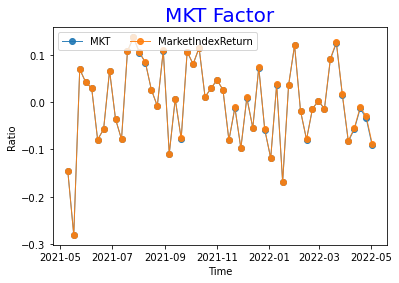

In [57]:
from matplotlib.pyplot import figure
import matplotlib.pyplot as plt
%matplotlib inline

factors = marketport[["Date", "MKT","MarketIndexReturn"]]

palette = plt.get_cmap('Set1')
 
num=0
for column in factors.drop('Date', axis=1):
    num+=1
    plt.plot(factors['Date'], factors[column], marker='o', linewidth=1, alpha=0.9, label=column)


plt.legend(loc=2, ncol=2)
plt.title("MKT Factor", loc='center', fontsize=20, fontweight=0, color='blue')
plt.xlabel("Time")
plt.ylabel("Ratio")
plt.show()

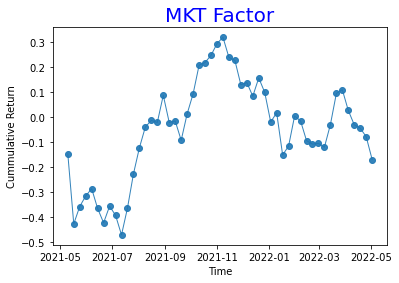

In [58]:
plt.plot(MKT_f.Date, np.cumsum(MKT_f.MKT), marker='o', linewidth=1, alpha=0.9, label=column)
plt.title("MKT Factor", loc='center', fontsize=20, fontweight=0, color='blue')
plt.xlabel("Time")
plt.ylabel("Cummulative Return")
plt.show()

## 3. SMB Factor (Fiona)

### 3.1 Using quantile method to get the dynamic portfolios for top cap 20%, and bottom cap 20% 

In [59]:
largeCap = largeCapSample.groupby(['Date']).apply(lambda 
                                                x: x.nlargest(round(0.2*len(x)),
                                                              ['MarketCap'])).reset_index(drop=True)

smallCap = largeCapSample.groupby(['Date']).apply(lambda 
                                                x: x.nsmallest(round(0.2*len(x)),
                                                              ['MarketCap'])).reset_index(drop=True)
largeCap.head()

,Date,Price,MarketCap,ActiveAddress,RiskFree,Asset,Return,week2_return,Npast52_return,ExcessReturn
0,2021-05-10,46406.331544,8.683518e+11,6062366.0,0.0001,BTC,-0.202895,0.187168,4.277670,-0.202995
1,2021-05-10,3582.328055,4.152052e+11,3482956.0,0.0001,ETH,-0.089013,0.699593,16.681685,-0.089113
2,2021-05-10,1.000012,5.737547e+10,564831.0,0.0001,USDT,-0.000014,0.000057,-0.000180,-0.000114
3,2021-05-10,296.493781,2.006374e+10,1530001.0,0.0001,LTC,-0.231293,0.722933,5.978366,-0.231393
4,2021-05-10,36.470417,1.987142e+10,24522.0,0.0001,UNI,-0.075351,0.156817,NaN,-0.075451


### 3.2 Using equal-weighted average method to get the SMB
SMB = equal-weighted average of returns on small portfolis - equal-weighted average of returns on large portfolis

In [60]:
largeport = largeCap.groupby('Date')['Return'].mean().reset_index(name='LargePortReturn')
smallport = smallCap.groupby('Date')['Return'].mean().reset_index(name='SmallPortReturn')
smallport['SMB'] = smallport['SmallPortReturn'] - largeport['LargePortReturn']
SMB_f = smallport[['Date','SMB']]

In [61]:
SMB_f.head()

,Date,SMB
0,2021-05-10,-0.189053
1,2021-05-17,-0.148497
2,2021-05-24,0.004411
3,2021-05-31,0.029201
4,2021-06-07,-0.033515


### <font color = 'green'> Test SMB

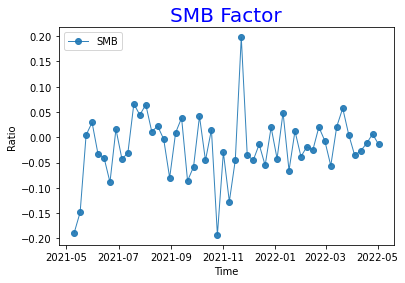

In [62]:
from matplotlib.pyplot import figure
import matplotlib.pyplot as plt
%matplotlib inline

factors = SMB_f

palette = plt.get_cmap('Set1')
 
num=0
for column in factors.drop('Date', axis=1):
    num+=1
    plt.plot(factors['Date'], factors[column], marker='o', linewidth=1, alpha=0.9, label=column)


plt.legend(loc=2, ncol=2)
plt.title("SMB Factor", loc='center', fontsize=20, fontweight=0, color='blue')
plt.xlabel("Time")
plt.ylabel("Ratio")
plt.show()

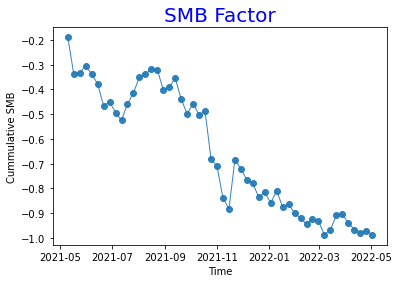

In [63]:
plt.plot(SMB_f.Date, np.cumsum(SMB_f.SMB), marker='o', linewidth=1, alpha=0.9, label=column)
plt.title("SMB Factor", loc='center', fontsize=20, fontweight=0, color='blue')
plt.xlabel("Time")
plt.ylabel("Cummulative SMB")
plt.show()

In [64]:
from sklearn.linear_model import LinearRegression
performance = {}


factors = SMB_f

features = factors.columns.tolist()
features.remove('Date')
target = "ExcessReturn"

for index in fullSample['Asset'].unique().tolist():
    syntax = f"Asset == '{index}'"
    segment = fullSample.query(syntax)
    
    reg = segment[['Date','ExcessReturn']].merge(factors, on = 'Date', how = 'outer')
    y = reg [target].copy()
    x = reg [features].copy()    
    model = LinearRegression()
    model.fit(x, y)
    y_pred = model.predict(x)    
    alpha = model.intercept_    
    performance[index] = alpha

In [65]:
alp_sig = pd.DataFrame(list(performance.items()), 
                       columns = ['Asset','Alpha'])
alp_sig = alp_sig.sort_values(by=['Alpha'], 
                              ascending = False)
alp_sig.head(10)

,Asset,Alpha
15,BRD,0.184809
112,VERI,0.077198
71,NFTX,0.073035
5,AMPL,0.061030
54,LDO,0.042443
68,MX,0.039463
58,LRC,0.039239
28,DDX,0.038331
87,QNT,0.037747
53,LBA,0.036303


In [66]:
alp_sig.tail(10)

,Asset,Alpha
91,RLC,-0.015632
118,YAM,-0.020123
14,BOND,-0.020142
63,MIR,-0.020689
31,DHT,-0.021127
52,LAMB,-0.022200
34,DOUGH,-0.024417
20,CND,-0.027407
73,Nsure,-0.029557
7,ARMOR,-0.041642


In [67]:
al = alp_sig.head(10).Asset.tolist()
hi = fullSample.query("Asset in @al ")

mk = hi.groupby('Asset')['MarketCap'].mean().reset_index(name = "AverageMarketCap")
mk

,Asset,AverageMarketCap
0,AMPL,1.413864e+08
1,BRD,2.613861e+07
2,DDX,1.038133e+08
3,LBA,3.336725e+06
4,LDO,1.430324e+08
5,LRC,1.201346e+09
6,MX,2.098705e+08
7,NFTX,5.182166e+07
8,QNT,1.963712e+09
9,VERI,1.026164e+08


In [68]:
asm = alp_sig.tail(10).Asset.tolist()
lo = fullSample.query("Asset in @asm ")

ml = lo.groupby('Asset')['MarketCap'].mean().reset_index(name = "AverageMarketCap")
ml

,Asset,AverageMarketCap
0,ARMOR,1.645346e+07
1,BOND,3.658616e+09
2,CND,2.233975e+07
3,DHT,1.449887e+07
4,DOUGH,5.668766e+06
5,LAMB,1.958875e+07
6,MIR,2.119788e+08
7,Nsure,1.057707e+06
8,RLC,2.613663e+08
9,YAM,3.997009e+06


## 4. VAL Factor (Lydia)

**Reshape to get two tables with: Npast52_return, Return(weekly)**

In [69]:
npast52 = largeCapSample.loc[:,['Date', 
                                  'Npast52_return', 
                                  'Asset']].pivot(index="Date", 
                                                  columns=["Asset"], 

                                                  values='Npast52_return').reset_index().rename_axis(None, 
                                                                                                     axis=1).sort_values('Date')


value_return = largeCapSample.loc[:,['Date','Asset','Return']].pivot(index='Date',
                                                              columns = ['Asset'],
                                                              values = 'Return').reset_index().rename_axis(None,
                                                                                                          axis=1).sort_values('Date')



In [70]:
cols=list(largeCapSample.Asset.unique())

npast52['top20'] = npast52[cols].quantile(q=0.8,axis=1, numeric_only=True, interpolation='linear') 
npast52['low20'] = npast52[cols].quantile(q=0.2,axis=1, numeric_only=True, interpolation='linear') 

**check whether Npast52 of a coin in a day is in low20 or top20, then calculate the weekly return mean of low20 and top20 , respectively**

In [71]:
VAL_low = (npast52[cols].apply(lambda x: x < npast52['low20']) * value_return[cols]).mean(axis=1, numeric_only=True)
VAL_top = (npast52[cols].apply(lambda x: x > npast52['top20']) * value_return[cols]).mean(axis=1, numeric_only=True)

**calculate Value factor using long-short method**

In [72]:
valueFactor = pd.DataFrame(columns = ['Date','VAL'])
valueFactor['Date'] = value_return['Date']
valueFactor['VAL'] = VAL_top - VAL_low

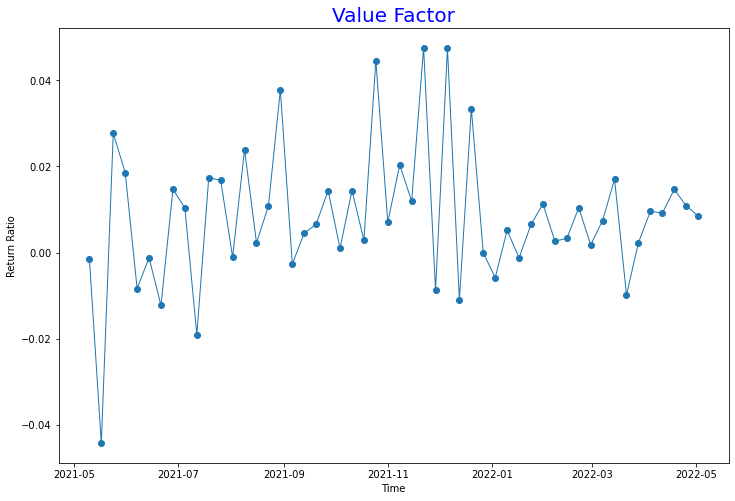

In [73]:
from matplotlib.pyplot import figure

plt.figure(figsize=(12,8))
 
plt.plot(valueFactor.Date, valueFactor.VAL, marker='o', linewidth=1)

plt.title("Value Factor", loc='center', fontsize=20, fontweight=0, color='blue')
plt.xlabel("Time")
plt.ylabel("Return Ratio")
plt.show()

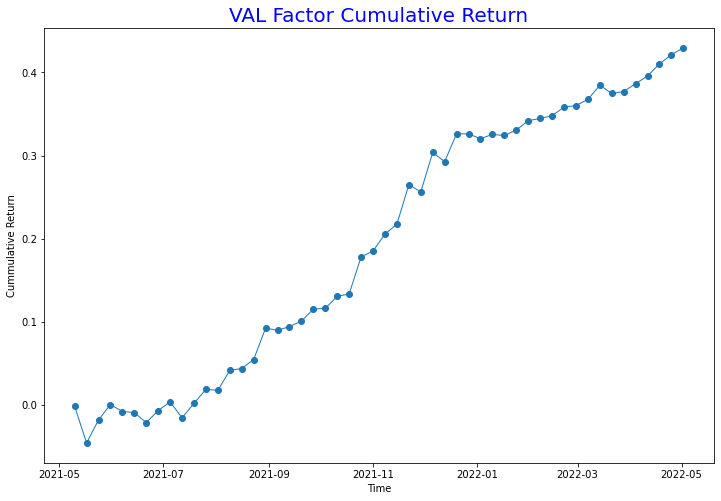

In [74]:
from matplotlib.pyplot import figure

figure(figsize = (12,8))
plt.plot(valueFactor.Date, np.cumsum(valueFactor.VAL), marker='o', linewidth=1)
plt.title("VAL Factor Cumulative Return", loc='center', fontsize=20, fontweight=0, color='blue')
plt.xlabel("Time")
plt.ylabel("Cummulative Return")
plt.show()

## 5. MOM Factor (Sean)

In [75]:
def getMomFactor(largeCapSample: pd.DataFrame):
    """This Method Returns Momentum Factor

    Args:
        largeCapSample (pd.DataFrame): Large Cap Sample

    Returns:
        momFactor (pd.DataFrame): Contains Momentum Factor
    """
    # Pivot largeCapSample to Get Return Matrix
    returnAll = largeCapSample.loc[:, ['Date',
                                   'Return',
                                       'Asset']].pivot(index="Date",
                                                       columns=["Asset"],
                                                       values='Return').reset_index().rename_axis(None,
                                                                                                  axis=1).sort_values('Date')
    
    # Pivot largeCapSample to Get Momentum Matrix(Past 2-Week Returns)
    momMatrix = largeCapSample.loc[:, ['Date',
                                       'week2_return',
                                       'Asset']].pivot(index="Date",
                                                       columns=["Asset"],
                                                       values='week2_return').reset_index().rename_axis(None,
                                                                                                        axis=1).sort_values('Date')

    # Calculate the Momentum Percentile
    col = []
    for colName in momMatrix.columns:
        if colName not in ['Date']:
            col.append(colName)
    momMatrix[col].head()

    momPt = pd.DataFrame(columns=['MOM20p',
                                  'MOM80p'])

    momPt['MOM20p'] = momMatrix[col].quantile(.2, axis=1)
    momPt['MOM80p'] = momMatrix[col].quantile(.8, axis=1)

    # Calculate MOM Factor
    MOM = pd.DataFrame({'Date': []})
    MOM['Date'] = returnAll.Date
    MOM['HighMomentum'] = returnAll[momMatrix[largeCapSample.Asset.unique()].apply(
        lambda x: x >= momPt['MOM80p'])].mean(axis=1, numeric_only=True)
    MOM['LowMomentum'] = returnAll[momMatrix[largeCapSample.Asset.unique()].apply(
        lambda x: x <= momPt['MOM20p'])].mean(axis=1, numeric_only=True)
    MOM['MOM'] = MOM.HighMomentum - MOM.LowMomentum
    momFactor = MOM.drop(columns=['HighMomentum', 'LowMomentum'])
    return momFactor


Text(0, 0.5, 'Cumulative Return')

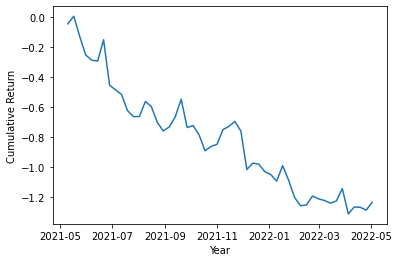

In [76]:
momFactor = getMomFactor(largeCapSample)

import matplotlib.pyplot as plt

plt.plot(momFactor.Date, np.cumsum(momFactor.MOM))
plt.xlabel('Year')
plt.ylabel('Cumulative Return')

## 6. NET Factor (Zachary)

The network factor (NET) is constructed by splitting the coins of the Core Sample into 3 groups due to the limitation of available coins. Particularly, each week we split the cryptocurrencies into three [30% 40% 30%] groups by the growth rate in total addresses with balance. The network factor (NET) is the return difference between the top and the bottom network portfolios. 

### Get Address Growth

In [88]:
Address = largeCapSample.loc[:,['Date', 'ActiveAddress', 'Asset']] \
                    .pivot(index = 'Date', columns = 'Asset', values = 'ActiveAddress')\
                    .reset_index() \
                    .rename_axis(None, axis = 1)

copy1 = Address.copy()
copy2 = copy1.shift()

Growth = copy1.copy()
for i in largeCapSample.Asset.unique():
    Growth[i] = np.log(copy1[i]) - np.log(copy2[i])

Growth['20Percentile'] = Growth.quantile(q=0.2, numeric_only = True, axis = 1)
Growth['80Percentile'] = Growth.quantile(q=0.8, numeric_only = True, axis = 1)

/Users/lydialiu/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


### Construct Network factor

In [89]:
Return = fullSample.loc[:,['Date', 'Return', 'Asset']] \
                    .pivot(index = 'Date', columns = 'Asset', values = 'Return')\
                    .reset_index() \
                    .rename_axis(None, axis = 1)

Marketcap = fullSample.loc[:,['Date', 'MarketCap', 'Asset']] \
                    .pivot(index = 'Date', columns = 'Asset', values = 'MarketCap')\
                    .reset_index() \
                    .rename_axis(None, axis = 1)

weight = Marketcap.copy()
weight['total_weight'] = Marketcap.sum(axis = 1, numeric_only=True)
weight[fullSample.Asset.unique()] = weight[fullSample.Asset.unique()].apply(lambda x: x/weight['total_weight'])
weight.drop(columns=['total_weight'])

Weighted_Return = Return.copy()
for i in fullSample.Asset.unique():
    Weighted_Return[i] = weight[i] * Return[i]

In [90]:
Return = largeCapSample.loc[:,['Date', 'Return', 'Asset']] \
                    .pivot(index = 'Date', columns = 'Asset', values = 'Return')\
                    .reset_index() \
                    .rename_axis(None, axis = 1)

NET = pd.DataFrame({'Date':[]})
NET['Date'] = Return.Date
NET['long'] = Return[Growth[largeCapSample.Asset.unique()].apply(lambda x: x >= Growth['80Percentile'])].mean(axis=1, numeric_only= True)
NET['short'] = Return[Growth[largeCapSample.Asset.unique()].apply(lambda x: x <= Growth['20Percentile'])].mean(axis=1, numeric_only= True)
NET.fillna(value = 0, inplace=True)
NET['NET'] = NET.long - NET.short
NET.drop(columns=['short', 'long'], inplace=True)

### Verification

Text(0, 0.5, 'Cumulative Return')

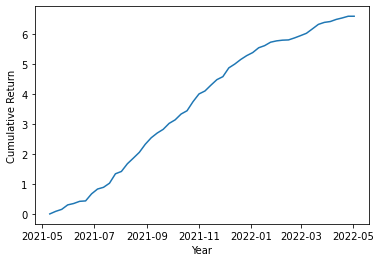

In [91]:
import matplotlib.pyplot as plt

plt.plot(NET.Date, np.cumsum(NET.NET))
plt.xlabel('Year')
plt.ylabel('Cumulative Return')

## 7.Regression Output
### 7.1 Output a list of alphas for all the crypto currencies using factors
Note: Only pick the top 100 cypto currencies from the latest week and check their alphas.

In [92]:
factorList = [MKT_f, SMB_f, valueFactor, momFactor, NET]
def ModelBuild(fullSample,
               factorList):
    from sklearn.linear_model import LinearRegression

    largeCapSample = fullSample.query("MarketCap > 1000000").groupby(['Date']).apply(lambda x: x.nlargest(100,['MarketCap'])).reset_index(drop=True)

    performance = {}

    ## find the top 100 cypto currencies at the last week

    latest = largeCapSample.Date.max()
    latestLarge = largeCapSample.query("Date == @latest")

    # factors = factors.merge(MOM_f, on = 'Date', how ='outer')
    from functools import reduce
    factors = reduce(lambda left, right:
                    pd.merge(left, 
                            right,
                            on='Date',
                            how='outer'),
                    factorList)

    features = factors.columns.tolist()
    features.remove('Date')
    target = "ExcessReturn"

    for index in latestLarge['Asset'].tolist():
        syntax = f"Asset == '{index}'"
        segment = fullSample.query(syntax)
        
        reg = segment[['Date','ExcessReturn']].merge(factors, on = 'Date', how = 'outer')
        y = reg [target].copy()
        x = reg [features].copy()    
        model = LinearRegression()
        model.fit(x, y)
        y_pred = model.predict(x)    
        alpha = model.intercept_    
        performance[index] = alpha
    alp_sig = pd.DataFrame(list(performance.items()), 
                       columns = ['Asset','Alpha'])
    alp_sig = alp_sig.sort_values(by=['Alpha'], 
                                ascending = False)
    return alp_sig

In [82]:
Alphas = ModelBuild(fullSample, factorList)
Alphas.head(10)

,Asset,Alpha
72,AMPL,0.100906
92,SAN,0.070714
37,MX,0.046408
69,BADGER,0.044669
95,BRD,0.034821
90,CREAM,0.024918
11,LEO,0.016262
7,MATIC,0.015469
64,FUN,0.013259
60,REP,0.011158


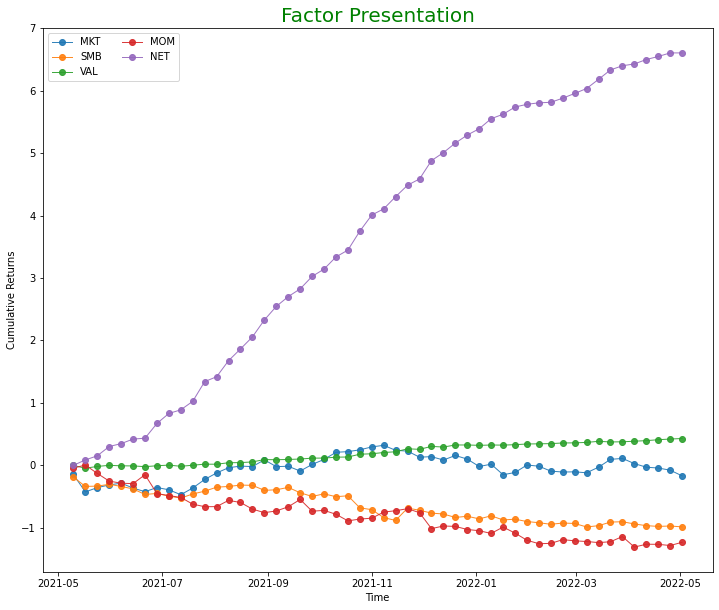

In [83]:
from functools import reduce
factors = reduce(lambda left, right:
                pd.merge(left, 
                        right,
                        on='Date',
                        how='outer'),
                factorList)

from matplotlib.pyplot import figure

plt.figure(figsize=(12,10))

palette = plt.get_cmap('Set1')
 
num=0
for column in factors.drop('Date', axis=1):
    num+=1
    plt.plot(factors['Date'], np.cumsum(factors[column]), marker='o',  linewidth=1, alpha=0.9, label=column)


plt.legend(loc=2, ncol=2)
plt.title("Factor Presentation", loc='center', fontsize=20, fontweight=0, color='green')
plt.xlabel("Time")
plt.ylabel("Cumulative Returns")
plt.show()